# Fault Scarp Analysis GUI

This code will allow you to interactively interrogate a profile accross a fault scarp. It will allow you to designate x and z values to represent the footwall, hanging wall, and scarp components of the fault system. You will filter the data into three separate subgroups representing these features. You can check your picks in a simplified diagram afterwards. The data will be saved to a csv file that can then be used for the Monte Carlo Statistics for Fault Scarp Calculator below.

Run this cell to install the packages needed, as well as the GUI to toggle on and off cells to simplify display of the program. Cells that can be toggled on and off do not need to be diplayed, but should still be run.

In [11]:
import os
import errno
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import math
import time
import matplotlib.pyplot as plt
import qgrid
%matplotlib nbagg

from IPython.display import HTML
from IPython.display import display
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

If you used the QGIS version of the data extraction process, you will need to convert your full dataset into individual profiles with data. This workflow will allow you to do that.

Import CSV of full dataset and resave as individual profiles

In [14]:
location_of_QGIS_shp = '/Users/frw313/Dropbox/ForFranklin/OutputForUserManual/'
csv_name = 'UserManual_Profile_PointswithData4_csv.csv'
full_csv = pd.read_csv(location_of_QGIS_shp + csv_name)

You will need a place to store these soon to be created profiles. Within the folder that contains the full dataset above, create a new folder named "Profiles."

Within that folder, create two new folders: "Raw" and "Processed"

Set the working directory and the folder containing all of the soon to be created csv files for the individual profiles.

In [15]:
# Working directory must be location of this folder/file
my_dir = location_of_QGIS_shp + 'Profiles/'


# You will need to create this in your working directory
folder = 'Raw/'

hide_toggle()

If you wish to analyze multiple transects or subsets of data as separate analyses, it will make sense to create an additional folder within the "Raw" folder, which will contain each subset. Here, I create one titled, "Transect 1" because I was interested in analyzing multiple transects and I needed a convenient way to keep them separate.

In [20]:
# Set to transect you are analyzing. This is the folder that contains all of the profiles
# You will need to create this in the Raw folder
my_transect = 'Transect1/'

for i in np.unique(full_csv['id']):
    profile = full_csv[full_csv['id'] == i]
    profile_name = my_dir + folder + my_transect + 'profile_' + str(i) + '.csv'
    profile.to_csv(profile_name)

Now, you should have newly created csv files - one for each individual fault scarp profile in the Raw -> Transect 1 folder.

If you used the ArcGIS workflow to extract the data, the profiles are already separated into individual csv files. Instead, just run this code below

In [18]:
# The organization of these files listed below may not seem obvious at first, however, humor this set up as it allows for 
# organization and smooth functionality of the code.
# the actual csv files for each profile should go in the final folder listed below.

# Location of the folder containing all of the extracted data from ArcGIS
location_of_QGIS_ = '/Users/frw313/Dropbox/ForFranklin/OutputForUserManual/'
# Within this folder, create a new folder titled, 'Profiles'
my_dir = location_of_QGIS_shp + 'Profiles/'
# Within this folder, create a new folder titled, 'Raw'
folder = 'Raw/'
# Within this folder, create a new folder titled by the name of the transect or subset of data these profiles represent.
#If you have multiple datasets this will help to separate them.
# Put your actual csv files for each transect into this folder
my_transect = 'Outputs_profiles_EqFlatFormation/'

You are now ready to analyze a profile. Set the transect name to the profile you wish to analyze.

In [21]:
# This is the input you change to investigate the fault scarp. This should be the raw profile as exported from QGIS
profile = "profile_1.csv"

Read in the data and start the GUI to display the profile

In [22]:
data = pd.read_csv(my_dir + folder + my_transect + profile)
data = data.rename(index=str, columns={"Unnamed: 0": "Point", "PointID": "Point", "ProfID": "Profile Number", "id": "Profile Number",
                                       "distance": "Distance","MAPNAME": "Map Name", "Geology" : "Map Name",
                                       "ABSMIN_MA": "Minimum Age (MA)", "Age_Min": "Minimum Age (MA)",
                                       "ABSMAX_MA": "Maximum Age (MA)", "Age_Max": "Maximum Age (MA)",
                                       "rvalue_1": "Elevation"})

# Call all the widget
qgrid_widget = qgrid.show_grid(data,show_toolbar=True)
qgrid_widget

hide_toggle()

Display the interactive GUI for the profile

<IPython.core.display.Javascript object>


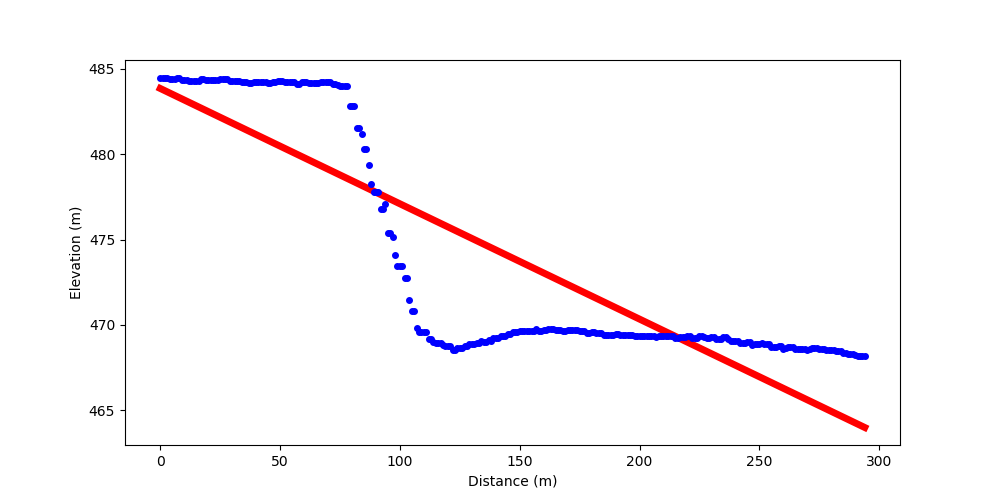

In [23]:
# All Data - this will plot the blue scatter plot in the background and will not change when you play with the widget
a = data['Distance']
b = data['Elevation']

#The updated data after widget manipulation
qgrid_df = qgrid_widget.get_changed_df()
x = qgrid_df['Distance']
z = qgrid_df['Elevation']

#plot the figure
fig, ax = plt.subplots(figsize = (10,5))
fit = np.polyfit(x, z, deg = 1)
linefw, = ax.plot(x, fit[0] * x + fit[1], linewidth=5, color = 'red')
scatter, = ax.plot(a, b, ms = 4, color = 'b', marker = 'o', ls = '')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')

#widget function
def handle_filter_changed(event,widget):
    qgrid_df = qgrid_widget.get_changed_df()
    x = qgrid_df['Distance']
    z = qgrid_df['Elevation']
    fit = np.polyfit(x, z, deg = 1)
    linefw.set_data(x , fit[0] * x + fit[1])
    fig.canvas.draw()
    scatter.set_data(a, b)
    print(fig.canvas.draw())
    
#turn widget on
qgrid_widget.on('filter_changed', handle_filter_changed)

hide_toggle()
    
#fig.savefig(my_dir + folder + my_transect + profile + 'img.jpg', format='jpg', dpi=1200)

Launch the interactive sliders to filter the data for fault components.

In [24]:
# Here you will launch the data filtering sliders
# Call all the widget
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Save values for each component of the fault scarp

In [42]:
# Save the data points for the FW
FW = qgrid_widget.get_changed_df()[['Distance','Elevation']]

In [44]:
# Save the data points for the HW
HW = qgrid_widget.get_changed_df()[['Distance','Elevation']]

In [43]:
# Save the data points for the SC
SC = qgrid_widget.get_changed_df()[['Distance','Elevation']]
#SC.dropna(axis=1);

Check your chosen geometry

<IPython.core.display.Javascript object>


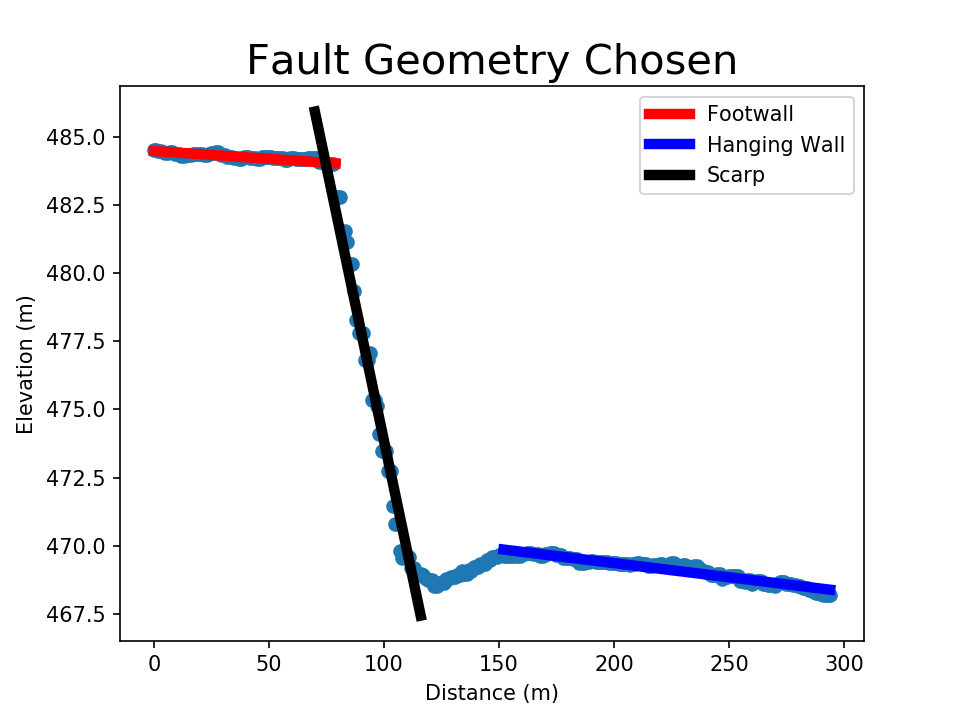

In [45]:
# Verify your choices and check for consistency. 
# Create lines from footwall, hanging wall, and scarp to test whether your picks were accurate

#create figure
fig = plt.figure()
plt.title('Fault Geometry Chosen', fontsize = 20)

#create best fit lines for the given data inputs (FW, HW, SC)
fw_fit = np.polyfit(FW['Distance'],FW['Elevation'],1)
fw_fit_fn = np.poly1d(fw_fit)

hw_fit = np.polyfit(HW['Distance'],HW['Elevation'],1)
hw_fit_fn = np.poly1d(hw_fit)

sc_fit = np.polyfit(SC['Distance'],SC['Elevation'],1)
sc_fit_fn = np.poly1d(sc_fit)

#plot
plt.scatter(a,b)
plt.plot(FW['Distance'],fw_fit_fn(FW['Distance']),'r', linewidth = 5, label = 'Footwall')
plt.plot(HW['Distance'],hw_fit_fn(HW['Distance']),'b', linewidth = 5, label = 'Hanging Wall')
plt.plot(SC['Distance'],sc_fit_fn(SC['Distance']),'k', linewidth = 5, label = 'Scarp')


#add legend
plt.legend(['Footwall', 'Hanging Wall', 'Scarp'])
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')

fig.savefig(my_dir + folder + my_transect + profile + 'fit.jpg', format='jpg', dpi=1200)

hide_toggle()

Save the geometry to a new csv

In [46]:
# Appends data to dataframe
Ages = pd.DataFrame(data[["Minimum Age (MA)","Maximum Age (MA)"]].values[0]).transpose()
frames = [FW,HW,SC,Ages]
output = pd.concat(frames,axis=1,ignore_index=True)

# Create new folder called processed - if this already exists then skip
processed_folder_path = str(my_dir + 'Processed/')
try:
    os.makedirs(processed_folder_path)
except OSError as e:
    if e.errno == errno.EEXIST:
        pass
    
# Create new folder in processed for the Transect - if it already exists then skip
processed_transect_folder_path = str(my_dir  + 'Processed/' + my_transect )
try:
    os.makedirs(processed_transect_folder_path)
except OSError as e:
    if e.errno == errno.EEXIST:
        pass

# Save file to this folder
output.to_csv(processed_transect_folder_path + '/processed_' + profile, index = False, header = False)

hide_toggle()

# Monte Carlo Slip Statistics for Fault Scarps Calculator

Toggle this cell on if you would like to change the fault geometry, number of samples, or directory of your transect profiles. The directory should contain the folders of transects that contain the individual fault profile geometries. Run this cell to initialize these values.

In [97]:
# Create table to contain fault components
# Fault is arranged as follows:
# Row 1: Dip mean, Dip deviation, Position mean, Position deviation
# Row 2: Dip min, max1, max2, end (trapezoidal distribution of dips)
# Row 3: Position min, max1, max2, end
# If trapezoidal distribution is goal, use rows 2 and 3
Fault = [[0,0,0,0],[60,70,80,90],[0,0,0.50,0.10]]

# Number of samples for Monte Carlo simulations
nsamples = 10000

# Set unit for ages so MCSST scales accordingly
# type one of the following - "million", "thousand"
age_unit = 'million'
#age_unit = 'thousand'

# Define directory for inputs and outputs
my_dir = processed_folder_path

hide_toggle()

Run this cell to calculate the slip statistics and export as them as a csv table and also build and export images of histograms of slip statistics from individual profiles.

<IPython.core.display.Javascript object>


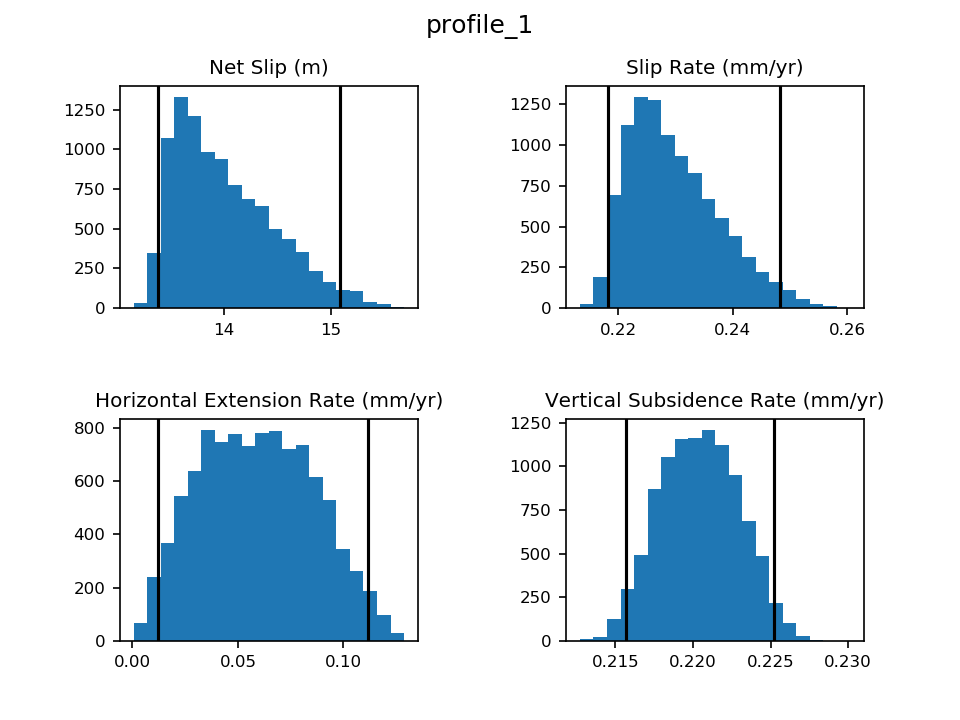

                                   Transect1                                    


,profile_1,Cumulative
Slip Mean (m),14.013,14.01
Slip Median (m),13.920,13.92
Slip Min (m),13.384,13.38
Slip Max (m),15.092,15.09
Slip 2STD (m),0.934,0.93
Slip Rate Mean (mm/yr),0.230,0.23
Slip Rate Median (mm/yr),0.228,0.23
Slip Rate Min (mm/yr),0.218,0.22
Slip Rate Max (mm/yr),0.248,0.25
Slip Rate 2STD (mm/yr),0.016,0.02


time =  1.1887807846069336  seconds


In [98]:
start_time = time.time()

# Create table to contain profile components
# X is arranged as follows:
# Row 1: HW intercept, HW dev., HW slope, HW slope dev. 
# Row 2: FW intercept, FW dev, FW slope, FW slope dev. 
# Row 3: SC intercept, SC dev., SC slope, Scarp slope dev.
X = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]

# Create empty table to eventually house matrix of slip statistics for each profile
slip_statistics_matrix = []

# Create empty list to house file names
file_names = []

# Set column headers for cSV tables
processed_csv_headers = ['HWx','HWy','FWx','FWy','SCx','SCy','Age_Min','Age_Max']

# Set up Dataframe to house statistics from profiles
statistics_dataframe = pd.DataFrame()

# Loop through Transect folders within directory
for folder in os.listdir(processed_folder_path):
    # Ignore DS file
    if folder[0] != '.':
       # Create folder to hold figures that will be created
        try:
            os.makedirs(str(processed_folder_path + folder + '/' + 'Outputs/'))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            # Loop through files within Transect folder
        for file in os.listdir(str(processed_folder_path + '/' + folder + '/')):

            # Ignore DS file and Outputs folder
            if file[0] == '.' or file == 'Outputs':
                pass
            else:
                if file.endswith(".csv"):
                    tbl = pd.read_csv(os.path.join(processed_folder_path, folder, file),header = None , names = processed_csv_headers)

                    # Extract the file name without the .csv or processed string
                    file = file[10:-4]

                    file_names.append(file)

                ############################################################################################
                    # Fit linear regressions to the HW, FW, and SC components
                    HW_fit = sm.OLS(tbl['HWy'],sm.add_constant(tbl['HWx']),missing='drop').fit()
                    FW_fit = sm.OLS(tbl['FWy'],sm.add_constant(tbl['FWx']),missing='drop').fit()
                    SC_fit = sm.OLS(tbl['SCy'],sm.add_constant(tbl['SCx']),missing='drop').fit()

                    # Create normal distribution for slope and intercept terms for each
                    HW_slope = np.random.normal(HW_fit.params[1], HW_fit.bse[1], nsamples)
                    FW_slope = np.random.normal(FW_fit.params[1], FW_fit.bse[1], nsamples)
                    SC_slope = np.random.normal(SC_fit.params[1], SC_fit.bse[1], nsamples)

                    HW_int = np.random.normal(HW_fit.params[0], HW_fit.bse[0], nsamples)
                    FW_int = np.random.normal(FW_fit.params[0], FW_fit.bse[0], nsamples)
                    SC_int = np.random.normal(SC_fit.params[0], SC_fit.bse[0], nsamples)

                ############################################################################################       
                # Create fault geometry distribution and position on scarp
                    # Normally distributed case
                    if Fault[0][0] != 0:
                        Dip = np.random.normal(Fault[0][0], Fault[0][1], nsamples)
                        Pos = np.random.normal(Fault[0][2], Fault[0][3], nsamples)
                    # Trapezoidally distributed case
                    else:

                        # Use elements if geometry defined above
                        Dip = []
                        a = Fault[1][0]
                        b1 = Fault[1][1]
                        b2 = Fault[1][2]
                        c = Fault[1][3] 

                        Pos = []
                        d = Fault[2][0]
                        e1 = Fault[2][1]
                        e2 = Fault[2][2]
                        f = Fault[2][3] 

                        for j in np.arange(nsamples):
                            # Dip
                            h = 1 / (b2 - b1 + 0.5 * (b1-a+c-b2))
                            u1 = np.random.rand(1)    

                            if u1 < (b2-b1) * h:
                                x = b1 + u1 / h
                            else:
                                u1 = (u1 - (b2-b1) * h) / (1 - (b2-b1) * h)
                                if u1 < (b1-a) / (c-b2+b1-a):
                                    x = a + ((u1 * (b1-a) * (c-b2+b1-a))**(1/2))
                                else:
                                    x = c - (((1-u1) * (c-b2) * (c-b2+b1-a))**(1/2))
                            Dip.append(x[0])

                            # Position    
                            h = 1 / (e2 - e1 + 0.5 * (e1-d+f-e2))
                            u1 = np.random.rand(1)

                            if u1 < (e2-e1) * h:
                                y = e1 + u1 / h
                            else:
                                u1 = (u1 - (e2-e1) * h) / (1 - (e2-e1) * h)
                                if u1 < (e1-d) / (f-e2+e1-d):
                                    y = d + ((u1 * (e1-d) * (f-e2+e1-d))**(1/2))
                                else:
                                    y = f - (((1-u1) * (f-e2) * (f-e2+e1-d))**(1/2))
                            Pos.append(y[0])

                ############################################################################################
                # Calculate net slip      

                    # Create variables
                    checkx1,checkx2, x1,x2,y1,y2, slope_distance,distance,angle,pos, fw_slip,hw_slip,net_slip = ([0]*nsamples for i in range(13))


                    # Sample with replacement from distributions created above
                    hw_slope = np.random.choice(HW_slope, nsamples, replace=True)
                    hw_intercept = np.random.choice(HW_int, nsamples, replace=True)
                    fw_slope = np.random.choice(FW_slope, nsamples, replace=True)
                    fw_intercept = np.random.choice(FW_int, nsamples, replace=True)
                    sc_slope = np.random.choice(SC_slope, nsamples, replace=True)
                    sc_intercept = np.random.choice(SC_int, nsamples, replace=True)
                    dip = np.deg2rad(np.random.choice(Dip, nsamples, replace=True))
                    Pos2 = np.random.choice(Pos, nsamples, replace=True)


                    for k in np.arange(nsamples):
                        x1[k] = (hw_intercept[k]-sc_intercept[k]) / (sc_slope[k] - hw_slope[k])
                        y1[k] = (sc_slope[k] * x1[k]) + sc_intercept[k]
                        x2[k] = (fw_intercept[k]-sc_intercept[k]) / (sc_slope[k] - fw_slope[k])
                        y2[k] = (sc_slope[k] * x2[k]) + sc_intercept[k]
                        slope_distance[k] = (((x2[k] - x1[k])**2) + ((y2[k]-y1[k])**2))   **(1/2)
                        distance[k] = slope_distance[k] * Pos2[k]
                        if x2[k] >= x1[k]:
                            angle[k] = np.arcsin(( abs(x2[k] - x1[k]) / slope_distance[k] ))
                            pos[k] = x1[k] + distance[k]* np.sin(angle[k])
                        else:
                            angle[k] = np.arcsin(( abs(x1[k] - x2[k]) / slope_distance[k] ))
                            pos[k] = x1[k] - distance[k]* np.sin(angle[k])

                    # Check that scarp is in the correct position. 
                    # If not, fill with average from the distribution

                    # Scenario 1: Downhill facing scarp left to right with HW slope > FW slope
                        if abs(hw_slope[k]) > abs(fw_slope[k]) and hw_slope[k] < 0:
                            checkx1[k] = (hw_intercept[k] - fw_intercept[k]) / (fw_slope[k] - hw_slope[k])
                            checkx2[k] = (hw_intercept[k] - sc_intercept[k]) / (sc_slope[k] - hw_slope[k])
                        if checkx2[k] > checkx1[k]:
                            net_slip[k] = float('nan')

                    # Scenario 2: Downhill facing scarp left to right with FW slope > HW slope
                        if abs(hw_slope[k]) < abs(fw_slope[k]) and hw_slope[k] < 0:
                            checkx1[k] = (hw_intercept[k] - fw_intercept[k]) / (fw_slope[k] - hw_slope[k])
                            checkx2[k] = (hw_intercept[k] - sc_intercept[k]) / (sc_slope[k] - hw_slope[k])
                        if checkx1[k] > checkx1[k]:
                            net_slip[k] = float('nan')

                    # Scenario 3: Downhill facing scarp right to left with HW slope > FW slope
                        if abs(hw_slope[k]) > abs(fw_slope[k]) and hw_slope[k] > 0:
                            checkx1[k] = (hw_intercept[k] - fw_intercept[k]) / (fw_slope[k] - hw_slope[k])
                            checkx2[k] = (hw_intercept[k] - sc_intercept[k]) / (sc_slope[k] - hw_slope[k])
                        if checkx1[k] > checkx1[k]:
                            net_slip[k] = float('nan')

                    # Scenario 4: Downhill facing scarp right to left with FW slope > HW slope
                        if abs(hw_slope[k]) < abs(fw_slope[k]) and hw_slope[k] > 0:
                            checkx1[k] = (hw_intercept[k] - fw_intercept[k]) / (fw_slope[k] - hw_slope[k])
                            checkx2[k] = (hw_intercept[k] - sc_intercept[k]) / (sc_slope[k] - hw_slope[k])
                        if checkx1[k] > checkx1[k]:
                            net_slip[k] = float('nan')

                    # Scenario 5: All other configurations just run it

                        # Calculate net slip
                        # If scarp not in right place for iteration, fill it with average from rest of values
                        if net_slip[k] == 'nan':
                            fw_slip[k] = (np.mean(pos) * (np.mean(sc_slope) - np.mean(fw_slope)) + np.mean(sc_intercept) - np.mean(fw_intercept))  / (np.sin(np.mean(dip)) + np.mean(fw_slope) * np.cos(np.mean(dip)))         
                            hw_slip[k] = (np.mean(pos) * (np.mean(hw_slope) - np.mean(sc_slope)) + np.mean(hw_intercept) - np.mean(sc_intercept))  / (np.sin(np.mean(dip)) + np.mean(hw_slope) * np.cos(np.mean(dip)))      
                            net_slip[k] = fw_slip[k] + hw_slip[k]
                        else: 
                            fw_slip[k] = (pos[k] * (sc_slope[k] - fw_slope[k]) + sc_intercept[k] - fw_intercept[k])  / (np.sin(dip[k]) + fw_slope[k] * np.cos(dip[k]))         
                            hw_slip[k] = (pos[k] * (hw_slope[k] - sc_slope[k]) + hw_intercept[k] - sc_intercept[k])  / (np.sin(dip[k]) + hw_slope[k] * np.cos(dip[k]))      
                            net_slip[k] = fw_slip[k] + hw_slip[k]

                ############################################################################################
                # Calculate slip statistics
                    # Age
                    
                    
                    age_min = [x for x in tbl['Age_Min'] if str(x) != 'nan'][0]
                    age_max = [x for x in tbl['Age_Max'] if str(x) != 'nan'][0]
                    if age_unit == 'million':
                        age_vector = np.random.uniform(age_min, age_max, nsamples) * 1000
                    elif age_unit =='thousand':
                        age_vector = np.random.uniform(age_min, age_max, nsamples)

                    # Calculate slip statistics
                    slip_mean = np.mean(net_slip)
                    slip_2std = np.std(net_slip)*2
                    slip_median = np.median(net_slip)
                    slip_low, slip_high = np.percentile(net_slip, [2.5 , 97.5])

                    slip_rate = net_slip / age_vector
                    slip_rate_mean = np.mean(slip_rate)
                    slip_rate_2std = np.std(slip_rate)*2
                    slip_rate_median = np.median(slip_rate)

                    slip_rate_low, slip_rate_high = np.percentile(slip_rate, [2.5 , 97.5])

                    slip_rate_horizontal = slip_rate * np.cos(dip)
                    slip_rate_horizontal_mean = np.mean(slip_rate_horizontal)
                    slip_rate_horizontal_2std = np.std(slip_rate_horizontal)*2
                    slip_rate_horizontal_median = np.median(slip_rate_horizontal)
                    slip_rate_horizontal_low , slip_rate_horizontal_high = np.percentile(slip_rate_horizontal, [2.5 , 97.5])     

                    slip_rate_vertical = slip_rate * np.sin(dip)
                    slip_rate_vertical_mean = np.mean(slip_rate_vertical)
                    slip_rate_vertical_2std = np.std(slip_rate_vertical)*2
                    slip_rate_vertical_median = np.median(slip_rate_vertical)
                    slip_rate_vertical_low , slip_rate_vertical_high = np.percentile(slip_rate_vertical, [2.5 , 97.5])

                    # convert age for dataframe
                    if age_unit == 'thousand':
                        age_min = age_min / 1000
                        age_max = age_max / 1000
                        
                    # Add these to matrix for each transect
                    slip_statistics = []
                    slip_statistics = [slip_mean, slip_median, slip_low, slip_high, slip_2std,
                                    slip_rate_mean, slip_rate_median, slip_rate_low, slip_rate_high, slip_rate_2std,
                                    slip_rate_horizontal_mean, slip_rate_horizontal_median, slip_rate_horizontal_low, slip_rate_horizontal_high, slip_rate_horizontal_2std,
                                    slip_rate_vertical_mean, slip_rate_vertical_median, slip_rate_vertical_low, slip_rate_vertical_high, slip_rate_vertical_2std,
                                    np.float64(age_min), np.float64(age_max)]

                # Built Stats Dataframe for all Transects 
                ss = pd.Series(slip_statistics)
                statistics_dataframe[str(file)] = ss.values

                # Build Plots
                plt.rc('font', size=8) 
                plt.rc('figure', titlesize = 12)
                fig, [[ax1,ax2], [ax3,ax4]] = plt.subplots(2 , 2 )
                plt.subplots_adjust(wspace=0.5,hspace=0.5)
                ax1.hist(net_slip, bins = 20)
                ax1.set_title('Net Slip (m)')
                ax1.axvline(slip_low, color = 'k')
                ax1.axvline(slip_high, color = 'k')
                ax2.hist(slip_rate, bins = 20)
                ax2.set_title('Slip Rate (mm/yr)')
                ax2.axvline(slip_rate_low, color = 'k')
                ax2.axvline(slip_rate_high, color = 'k')
                ax3.hist(slip_rate_horizontal, bins = 20)
                ax3.set_title('Horizontal Extension Rate (mm/yr)')
                ax3.axvline(slip_rate_horizontal_low, color = 'k')
                ax3.axvline(slip_rate_horizontal_high, color = 'k')
                ax4.hist(slip_rate_vertical, bins = 20)
                ax4.set_title('Vertical Subsidence Rate (mm/yr)')
                ax4.axvline(slip_rate_vertical_low, color = 'k')
                ax4.axvline(slip_rate_vertical_high, color = 'k')
                fig.suptitle(str(file))
                #fig.tight_layout()
                plt.show()
            # It will overwrite earlier saved plots
                fig.savefig(str(processed_folder_path) + str(folder) + '/Outputs/' + str(file) + '.png', dpi = 600)


    #Save statistics datafrme to csv    
    
        statistics_dataframe = statistics_dataframe.rename({0:'Slip Mean (m)', 1:'Slip Median (m)', 2:'Slip Min (m)', 3:'Slip Max (m)', 4:'Slip 2STD (m)',
                                        5:'Slip Rate Mean (mm/yr)', 6:'Slip Rate Median (mm/yr)', 7:'Slip Rate Min (mm/yr)', 8:'Slip Rate Max (mm/yr)', 9:'Slip Rate 2STD (mm/yr)',
                                        10:'Slip Rate Horizontal Mean (mm/yr)', 11: 'Slip Rate Horizontal Median (mm/yr)', 12:'Slip Rate Horizontal Min (mm/yr)', 13:'Slip Rate Horizontal Max (mm/yr)', 14:'Slip Rate Horizontal 2STD (mm/yr)',
                                        15:'Slip Rate Vertical Mean (mm/yr)', 16:'Slip Rate Vertical Median (mm/yr)', 17: 'Slip Rate Vertical Min (mm/yr)', 18: 'Slip Rate Vertical Max (mm/yr)', 19: 'Slip Rate Vertical 2STD (mm/yr)',
                                                                     20: 'Age Min (Ma)', 21: 'Age Max (Ma)' })
        statistics_dataframe['Cumulative'] = statistics_dataframe.sum(axis=1).round(2)
        statistics_dataframe['Cumulative'].loc[['Age Min (Ma)','Age Max (Ma)']] = 'N/A'
        
        for row in ['Slip 2STD (m)','Slip Rate 2STD (mm/yr)','Slip Rate Horizontal 2STD (mm/yr)', 'Slip Rate Vertical 2STD (mm/yr)']:
            statistics_dataframe.loc[row,'Cumulative'] = np.sqrt(np.sum(np.array(statistics_dataframe.loc[row][:-1])**2)).round(2)
    
        statistics_dataframe[:-2] = statistics_dataframe.iloc[:-2].round(3)
 
        width = os.get_terminal_size().columns
        print(str(folder).center(width))
        display(statistics_dataframe)
        statistics_dataframe.to_csv(str(processed_folder_path) + str(folder)  + '/Outputs/' + str(folder) + 'Statistics.csv', encoding='utf-8', index=True, header=True )


print('time = ', time.time() - start_time, ' seconds')

# Save into an easy format for QGIS to associate with QGIS Profiles Shapefile.

col_names = []
statistics_dataframe_QGIS = statistics_dataframe.drop(labels='Cumulative', axis=1)
for col in statistics_dataframe_QGIS.columns:
    col_names.append(col.split('_')[1])
statistics_dataframe_QGIS.columns = col_names
statistics_dataframe_QGIS = statistics_dataframe_QGIS.T

statistics_dataframe_QGIS.to_csv(str(location_of_QGIS_shp + csv_name[:-4] + '_join'+ '.csv'), encoding='utf-8', index=True, header=True )

# Create CSVT file for CSV file
data_types = []
for col in statistics_dataframe_QGIS:
    data_types.append('"Real"')
    
pd.DataFrame(data_types).T.to_csv(str(location_of_QGIS_shp + csv_name[:-4] + '_join'+ '.csvt'), encoding='utf-8', index=False, header=False)


hide_toggle()